# Starbucks Customer Segmentation

## 1. Outline <a name="outline"></a>
1. [Outline](#outline)
2. [Introduction](#introduction)
3. [Libraries](#libraries)
4. [Data Loading](#dataloading)
5. [Data Cleaning](#datacleaning)
6. [Exploratory Data Analysis](#exploratorydataanalysis)
7. [Data Preprocessing](#datapreprocessing)
8. [Modeling](#modeling)
9. [Evaluation](#evaluation)
10. [Model Tuning](#modeltuning)
11. [Conclusion](#conclusion)

## 2. Introduction <a name="introduction"></a>

### 2.1 Business Understanding

The data set contains simulated data of customer behavoir on the Starbucks rewards mobile app. The goal of this scenario is to determine which demographic groups respond best to which offer type. To have good understanding about the data and main goal, we are going to dive deep into the data by answering these following questions:
1. How is the demographic of the customer?
2. How is the distribution of event?
3. How is the proportion of successful offer and unsuccessful offer?
4. How is the distribution of successful offer by age?
5. How is the distribution of successful offer by gender?

### 2.2 Data Understanding

The data contains 3 files:
- portfolio.json -> Contains offer id and data about each offer.
- profile.json -> Contains demographic data for each customer.
- transcript.json -> Contains record of transactions, offers recieved, offers viewed, offers completed.  
  
**portfolio.json**  
|Column|Type|Description|
|------|----|-----------|
|id|string|Offer id|
|offer_type|string|Type bogo (buy one get one),  discount, informational|
|difficulty|int|Minimum required spend to complete an offer|
|reward|int|Reward given for completing an offer|
|duration|int|Time for offer to be open, in days|
|channels|list of strings|Web, email, mobile, social|  
  
**profile.json**  
|Column|Type|Description|
|------|----|-----------|
|age|int|Age of the customer|
|became_member_on|int|Date when customer create an app account|
|gender|string|Gender of the customer (F, M ,O)|
|id|string|Customer id|
|income|float|Customer's income|  
  
**transcript.json**  
|Column|Type|Description|
|------|----|-----------|
|event|string|Record description|
|person|string|Customer id|
|time|int|Time in hours since start of test|
|value|dictionary|offer id, amount, reward|

## 3. Libraries <a name="libraries"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

## 4. Data Loading <a name="dataloading"></a>

In [2]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

pd.set_option('display.max_rows', None)

## 5. Data Cleaning <a name="datacleaning"></a>

### 5.1 Data Transformation & Missing Values

**Portfolio Dataset**

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

The cleaning data process for portfolio dataset are:
- Rename id to offer_id
- Extract data into column

In [6]:
# rename id
portfolio.rename(columns={'id':'offer_id', 'reward':'spent_reward'},inplace=True)

# One hot encode channels
channels = []
for channel in portfolio['channels']:
  channels.extend(channel)

channels = set(channels)

for channel in channels:
  portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)

portfolio.drop(columns=['channels'], inplace=True)

# One hot encode offer_type
# portfolio = pd.get_dummies(portfolio, columns=['offer_type'])

In [7]:
portfolio

,spent_reward,difficulty,duration,offer_type,offer_id,email,social,mobile,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,0,1,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,0,1,1


**Profile Dataset**

In [8]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [10]:
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

The cleaning data process for profile dataset are:
- There are 2175 missing values at gender and income column from 17000. Drop this data.
- Rename id to customer_id
- Change became_member_on data type to date
- Add year became member

In [11]:
profile[profile.gender.isna() & profile.income.isna()].shape

(2175, 5)

The missing values in gender is same row as in income.

In [12]:
profile.dropna(subset=['gender'], inplace=True)

In [13]:
profile.isna().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [14]:
# rename id into customer_id
profile.rename(columns={'id':'customer_id'},inplace=True)

# change datatype
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],format = '%Y%m%d')

# add member year column
profile['member_year'] = profile['became_member_on'].dt.year

In [15]:
profile.head()

,gender,age,customer_id,became_member_on,income,member_year
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017


**Transcript Dataset**

In [16]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [17]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [18]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

The cleaning data process for transcript dataset are:
- Rename person to customer_id.
- Extract value column to new column.

In [19]:
keys = []
for value in transcript['value']:
  keys.extend(value.keys())

value_keys = set(keys)
print(value_keys)

{'reward', 'offer id', 'amount', 'offer_id'}


In [20]:
# extract offer id function
def extract_offer_id(value):
  if 'offer_id' in value.keys():
    return value['offer_id']
  if 'offer id' in value.keys():
    return value['offer id']
  else:
    return 0

In [21]:
# rename person to customer_id
transcript.rename(columns={'person':'customer_id'},inplace=True)

# extract value column
transcript['offer_id'] = transcript['value'].apply(extract_offer_id)
transcript['amount'] = transcript['value'].apply(lambda x: x['amount'] if 'amount' in x.keys() else 0)
transcript['offer_completed_reward'] = transcript['value'].apply(lambda x: x['reward'] if 'reward' in x.keys() else 0)

# drop value column
transcript.drop(columns=['value'],inplace=True)

In [22]:
transcript.head(10)

,customer_id,event,time,offer_id,amount,offer_completed_reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0
5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0
6,c4863c7985cf408faee930f111475da3,offer received,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,0.0,0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0
9,31dda685af34476cad5bc968bdb01c53,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0


In [23]:
transcript.shape

(306534, 6)

### 5.2 Merge Dataset

**Determine Successful Offer**  
An offer counted as successful if the number of offer viewed is equal to the number of offer completed

In [24]:
customer_offer = transcript[transcript['offer_id']!=0].groupby(['customer_id','offer_id','event'])['amount'].count().unstack().reset_index(level=[0,1])
customer_offer.fillna(0, inplace=True)

customer_offer['successful_offer'] = customer_offer['offer completed'] >= customer_offer['offer viewed']
customer_offer.head()

event,customer_id,offer_id,offer completed,offer received,offer viewed,successful_offer
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,True
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,1.0,1.0,False
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,False
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,True
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,True


In [25]:
customer_offer.shape

(63288, 6)

In [26]:
df_transaction = customer_offer.merge(profile, on="customer_id", how="inner")
df = df_transaction.merge(portfolio, on="offer_id", how="left")

In [27]:
offer_ids = list(df['offer_id'].unique())
offer_key = {}
for index, offer in enumerate(offer_ids):
  offer_key[offer] = index + 1

df['offer_id'] = df['offer_id'].apply(lambda x: offer_key[x])

In [28]:
df.head(10)

,customer_id,offer_id,offer completed,offer received,offer viewed,successful_offer,gender,age,became_member_on,income,member_year,spent_reward,difficulty,duration,offer_type,email,social,mobile,web
0,0009655768c64bdeb2e877511632db8f,1,1.0,1.0,0.0,True,M,33,2017-04-21,72000.0,2017,2,10,7,discount,1,0,1,1
1,0009655768c64bdeb2e877511632db8f,2,0.0,1.0,1.0,False,M,33,2017-04-21,72000.0,2017,0,0,4,informational,1,0,1,1
2,0009655768c64bdeb2e877511632db8f,3,0.0,1.0,1.0,False,M,33,2017-04-21,72000.0,2017,0,0,3,informational,1,1,1,0
3,0009655768c64bdeb2e877511632db8f,4,1.0,1.0,1.0,True,M,33,2017-04-21,72000.0,2017,5,5,5,bogo,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,5,1.0,1.0,1.0,True,M,33,2017-04-21,72000.0,2017,2,10,10,discount,1,1,1,1
5,0011e0d4e6b944f998e987f904e8c1e5,6,1.0,1.0,1.0,True,O,40,2018-01-09,57000.0,2018,5,20,10,discount,1,0,0,1
6,0011e0d4e6b944f998e987f904e8c1e5,7,1.0,1.0,1.0,True,O,40,2018-01-09,57000.0,2018,3,7,7,discount,1,1,1,1
7,0011e0d4e6b944f998e987f904e8c1e5,2,0.0,1.0,1.0,False,O,40,2018-01-09,57000.0,2018,0,0,4,informational,1,0,1,1
8,0011e0d4e6b944f998e987f904e8c1e5,3,0.0,1.0,1.0,False,O,40,2018-01-09,57000.0,2018,0,0,3,informational,1,1,1,0
9,0011e0d4e6b944f998e987f904e8c1e5,8,1.0,1.0,1.0,True,O,40,2018-01-09,57000.0,2018,5,5,7,bogo,1,0,1,1


## 6. Exploratory Data Analysis <a name="exploratorydataanalysis"></a>

**Customer Demographic**

<AxesSubplot:xlabel='member_year', ylabel='Count'>

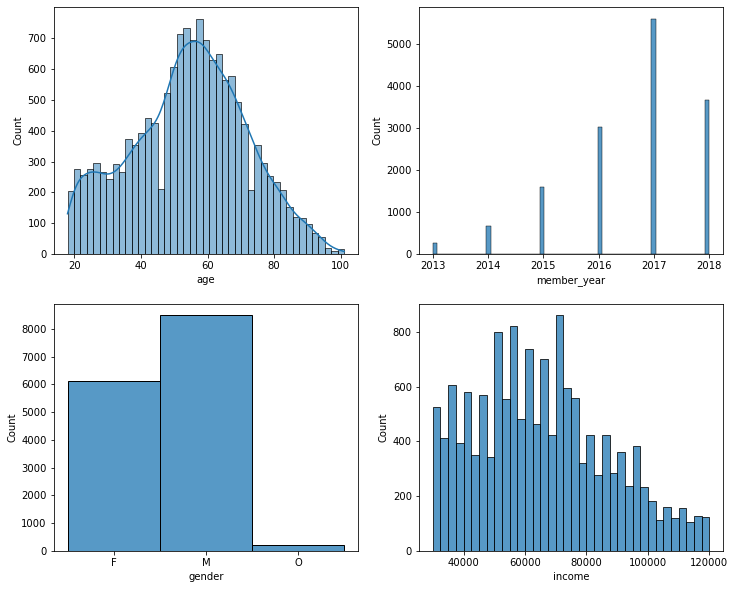

In [29]:
fig, axs = plt.subplots(2,2, figsize=(12,10))

# Age
sns.histplot(data=profile['age'], kde=True, ax=axs[0,0])

# Gender
sns.histplot(data=profile['gender'], ax=axs[1,0])

# Income
sns.histplot(data=profile['income'], ax=axs[1,1])

# Member year
sns.histplot(data=profile['member_year'], ax=axs[0,1])

In [30]:
profile.describe()

,age,income,member_year
count,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,2016.620169
std,17.383705,21598.299410,1.198245
min,18.000000,30000.000000,2013.000000
25%,42.000000,49000.000000,2016.000000
50%,55.000000,64000.000000,2017.000000
75%,66.000000,80000.000000,2017.000000
max,101.000000,120000.000000,2018.000000


In [31]:
profile.groupby('gender')['gender'].count()

gender
F    6129
M    8484
O     212
Name: gender, dtype: int64

**Transaction data**

<AxesSubplot:xlabel='event', ylabel='Count'>

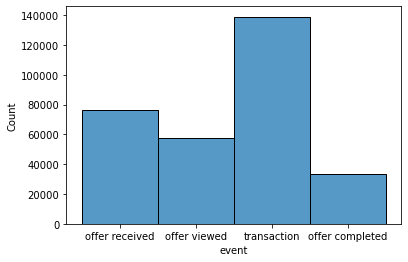

In [32]:
sns.histplot(data=transcript['event'])

<AxesSubplot:xlabel='offer_type', ylabel='Count'>

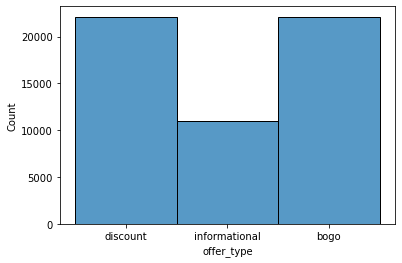

In [33]:
sns.histplot(data=df['offer_type'])

**Demographic by successful offer**

<AxesSubplot:xlabel='age', ylabel='Count'>

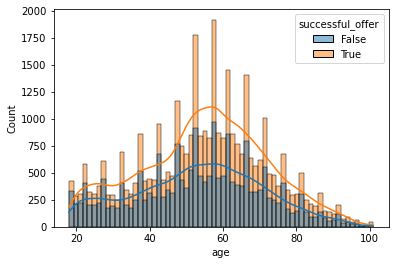

In [34]:
sns.histplot(df, x='age', hue='successful_offer', kde=True)

In [63]:
df.groupby('successful_offer')['age'].mean()

successful_offer
False    53.383638
True     54.908070
Name: age, dtype: float64

<AxesSubplot:xlabel='gender', ylabel='Count'>

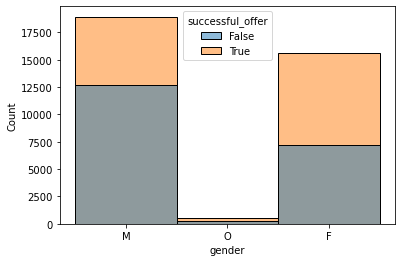

In [35]:
sns.histplot(df, x='gender', hue='successful_offer')

<AxesSubplot:xlabel='income', ylabel='Count'>

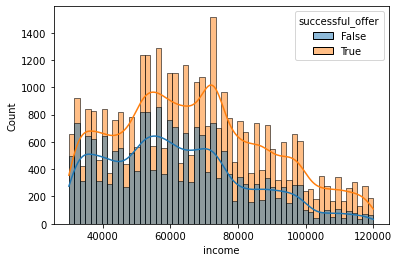

In [36]:
sns.histplot(df, x='income', hue='successful_offer', kde=True)

<AxesSubplot:xlabel='offer_type', ylabel='Count'>

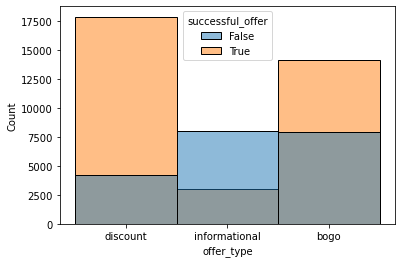

In [37]:
sns.histplot(df, x='offer_type', hue='successful_offer')

<AxesSubplot:xlabel='offer_id', ylabel='count'>

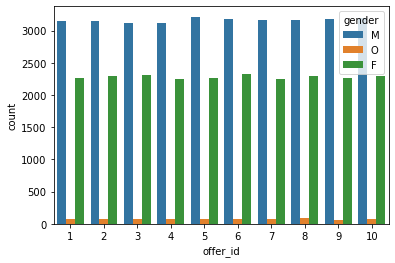

In [38]:
sns.countplot(data=df, x='offer_id', hue='gender')

<AxesSubplot:xlabel='offer_id', ylabel='count'>

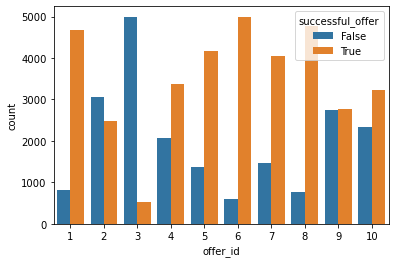

In [39]:
sns.countplot(data=df, x='offer_id', hue='successful_offer')

<AxesSubplot:xlabel='successful_offer', ylabel='count'>

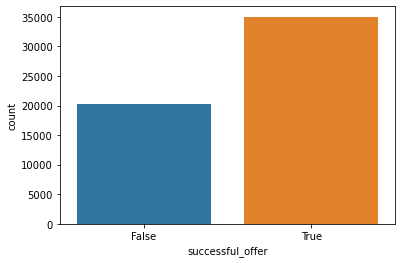

In [40]:
sns.countplot(data=df, x='successful_offer')

In [64]:
df.groupby('successful_offer')['successful_offer'].count()

successful_offer
False    20217
True     35005
Name: successful_offer, dtype: int64

## 7. Data Preprocessing <a name="datapreprocessing"></a>

In this process, I am going to conduct the following method:
1. Filter the important features.
2. Split dataset.
3. Encode the categorical data.
4. Scale dataset.

In [41]:
df.head()

,customer_id,offer_id,offer completed,offer received,offer viewed,successful_offer,gender,age,became_member_on,income,member_year,spent_reward,difficulty,duration,offer_type,email,social,mobile,web
0,0009655768c64bdeb2e877511632db8f,1,1.0,1.0,0.0,True,M,33,2017-04-21,72000.0,2017,2,10,7,discount,1,0,1,1
1,0009655768c64bdeb2e877511632db8f,2,0.0,1.0,1.0,False,M,33,2017-04-21,72000.0,2017,0,0,4,informational,1,0,1,1
2,0009655768c64bdeb2e877511632db8f,3,0.0,1.0,1.0,False,M,33,2017-04-21,72000.0,2017,0,0,3,informational,1,1,1,0
3,0009655768c64bdeb2e877511632db8f,4,1.0,1.0,1.0,True,M,33,2017-04-21,72000.0,2017,5,5,5,bogo,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,5,1.0,1.0,1.0,True,M,33,2017-04-21,72000.0,2017,2,10,10,discount,1,1,1,1


In [42]:
y = df['successful_offer']
X = df.drop(columns=['customer_id','became_member_on','successful_offer'])

In [43]:
X.head()

,offer_id,offer completed,offer received,offer viewed,gender,age,income,member_year,spent_reward,difficulty,duration,offer_type,email,social,mobile,web
0,1,1.0,1.0,0.0,M,33,72000.0,2017,2,10,7,discount,1,0,1,1
1,2,0.0,1.0,1.0,M,33,72000.0,2017,0,0,4,informational,1,0,1,1
2,3,0.0,1.0,1.0,M,33,72000.0,2017,0,0,3,informational,1,1,1,0
3,4,1.0,1.0,1.0,M,33,72000.0,2017,5,5,5,bogo,1,1,1,1
4,5,1.0,1.0,1.0,M,33,72000.0,2017,2,10,10,discount,1,1,1,1


In [44]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42, test_size=0.33)
# X_train, X_val, y_train,y_val = train_test_split(X_train,y_train,random_state=42, test_size=0.33)

In [45]:
X.shape, X_train.shape,X_test.shape

((55222, 16), (36998, 16), (18224, 16))

In [46]:
preprocess = make_column_transformer(
  (StandardScaler(),['age','income','difficulty','duration','spent_reward']),
  (OneHotEncoder(handle_unknown = 'ignore'), ['gender','member_year','offer_type','offer_id']),
)

## 8. Modeling <a name="modeling"></a>

In [47]:
lr = LogisticRegression()
svc = SVC()
rf = RandomForestClassifier()

In [48]:
# logistic Regression
pipeline_lr = make_pipeline(preprocess, lr)
pipeline_lr.fit(X_train,y_train)
y_pred_lr = pipeline_lr.predict(X_test)

In [49]:
# Support Vector Machines
pipeline_svc= make_pipeline(preprocess, svc)
pipeline_svc.fit(X_train,y_train)
y_pred_svc = pipeline_svc.predict(X_test)

In [50]:
# Random Forest
pipeline_rf = make_pipeline(preprocess, rf)
pipeline_rf.fit(X_train,y_train)
y_pred_rf = pipeline_rf.predict(X_test)

## 9. Evaluation <a name="evaluation"></a>

In [51]:
# Logistic Regression
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

       False       0.71      0.54      0.61      6684
        True       0.77      0.87      0.81     11540

    accuracy                           0.75     18224
   macro avg       0.74      0.71      0.71     18224
weighted avg       0.74      0.75      0.74     18224



<AxesSubplot:>

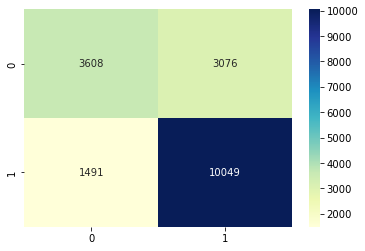

In [52]:
sns.heatmap(confusion_matrix(y_test,y_pred_lr),annot = True, cmap="YlGnBu",fmt='g')

In [53]:
# Support Vector Machine
print(classification_report(y_test,y_pred_svc))

              precision    recall  f1-score   support

       False       0.72      0.63      0.67      6684
        True       0.80      0.86      0.83     11540

    accuracy                           0.77     18224
   macro avg       0.76      0.75      0.75     18224
weighted avg       0.77      0.77      0.77     18224



<AxesSubplot:>

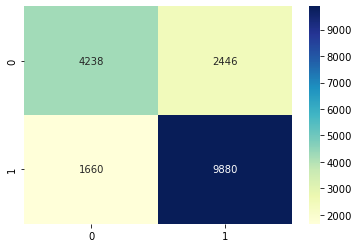

In [54]:
sns.heatmap(confusion_matrix(y_test,y_pred_svc),annot = True, cmap="YlGnBu",fmt='g')

In [55]:
# Random Forest
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

       False       0.65      0.61      0.63      6684
        True       0.78      0.81      0.80     11540

    accuracy                           0.74     18224
   macro avg       0.72      0.71      0.71     18224
weighted avg       0.73      0.74      0.74     18224



<AxesSubplot:>

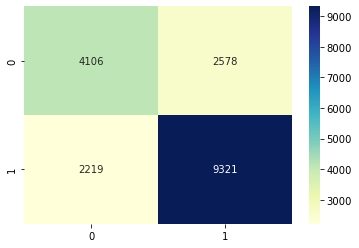

In [56]:
sns.heatmap(confusion_matrix(y_test,y_pred_rf),annot = True, cmap="YlGnBu",fmt='g')

SVM

## 10. Model Tuning <a name="modeltuning"></a>

In [57]:
parameters = {
  'model__C':[1,10,100],
  'model__kernel':['linear','rbf'],
  'model__gamma':['scale','auto']
}

In [58]:
pipeline = Pipeline([
  ('preprocess',preprocess),
  ('model',svc)
])
clf = GridSearchCV(pipeline, param_grid=parameters )
clf.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'income',
                                                                          'difficulty',
                                                                          'duration',
                                                                          'spent_reward']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['gender',
                                              

In [60]:
print('Best params:', clf.best_params_)
print('Best score:', clf.best_score_)

Best params: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best score: 0.777339253295734


## 11. Conclusion <a name="conslusion"></a>

Among 3 model I used in this project. SVM is the most perform model with accuracy 0.77. However, after tuning the hyperparameters, the improvement of accuracy is not significant.